<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Introducing the landing ellipse uncertainty

Our goal here is to include the uncertainty in the landing position in the map for site selection.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.vector_management import add_path_to_map
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.ellipse_uncertainty import *
from skdiscovery.utilities.planetary.fuzzy_logic import *

import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

## Import the raw favorability

First. we select a raw favorability map. This process can be done on the raw landing, scientific, or selection favorability. In the last two cases, either the threshold targets or the traverse paths can be used. If several scientific and selection favorability were created depending on the exploration scenarios, each one should be processed independantly.

In [4]:
# constraint_type = "Landing"
# constraint_type = "Scientific"
constraint_type = "Selection"

# selection_method = ""
# selection_method = "Threshold"
selection_method = "Paths"

# exploration_characteristics = ""
exploration_characteristics = "4_Scenarios_25"
# exploration_characteristics = "StandingWater_HesperianNoachian_25"
# exploration_characteristics = "StandingWater_EarlyMiddleNoachian_25"
# exploration_characteristics = "GroundWater_AllTime_25"
# exploration_characteristics = "WaterMagma_AllTime_25"

raster_name_affix = constraint_type
if selection_method != "":
    raster_name_affix += "_" + selection_method
if exploration_characteristics != "":
    raster_name_affix += "_" + exploration_characteristics
    
print(raster_name_affix)

Selection_Paths_4_Scenarios_25


In [5]:
raster_rawfavorability = open_raster(base_folder + output_folder + 'Results_RawFavorability_' + raster_name_affix + '.tif')
print_raster_info(raster_rawfavorability)
raster_rawfavorability_array = get_raster_array(raster_rawfavorability)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


<IPython.core.display.Javascript object>


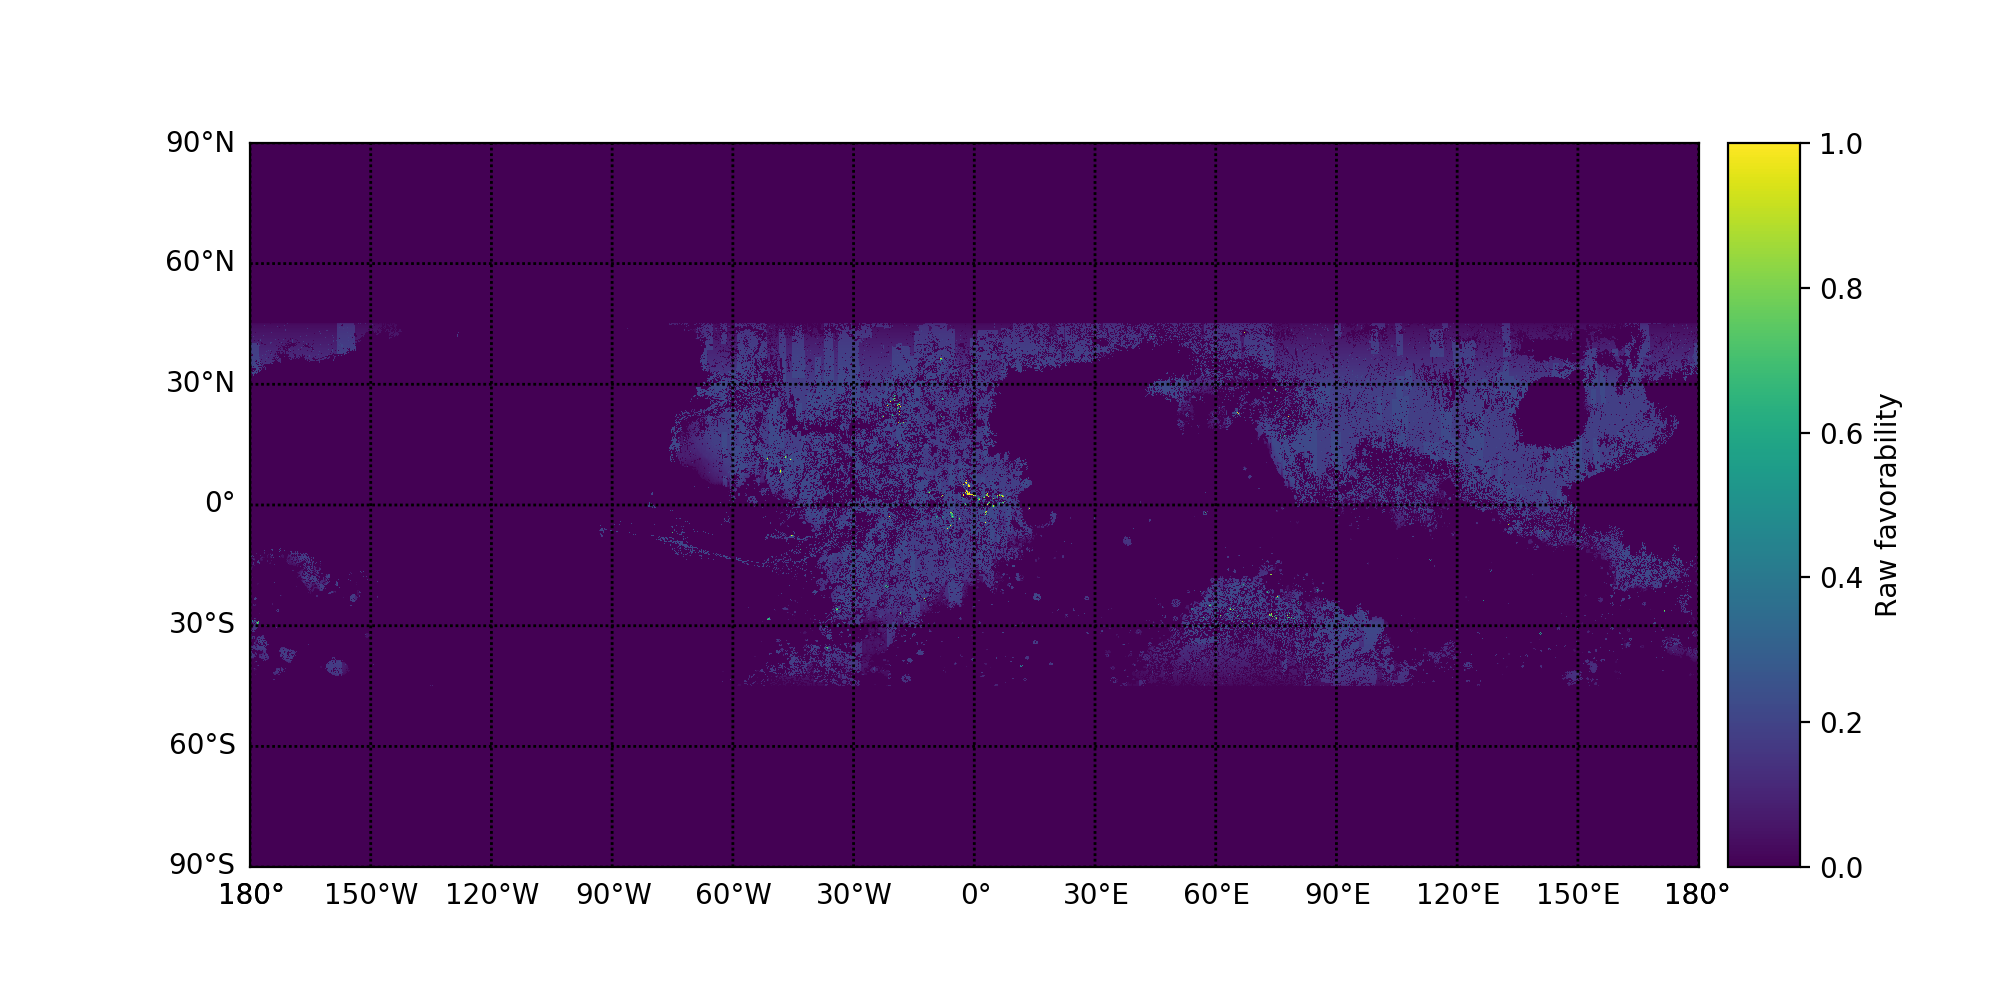

In [6]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, raster_rawfavorability_array, 'Raw favorability')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

## Compute the uncertainty due to the landing ellipse

The landing ellipse takes into account the uncertainty of the landing location. This uncertainty is due to trajectory variations and possible navigation errors during the descent. To take it into account, we compute a moving average and standard deviation on the raw favorability using an elliptical neighbordhood.

**Ellipse parameters**  
<br>
An ellipse is based on 3 parameters: a major axis length, a minor axis length, and an azimuth to define the major axis orientation.  
<br>
<dl>
  <dt>MSL</dt>
  <dd>25 &times; 20 km, roughly E-W [[Golombek et al., 2012](http://doi.org/10.1007/s11214-012-9916-y)]</dd>
  <dt>Mars 2020</dt>
  <dd>25 &times; 20 km, hopefully 16 &times; 14 km, 81&deg; - 112&deg; [[Chen, 2014](https://marsnext.jpl.nasa.gov/workshops/2014_05/05_LSW1_EDL_Eng_Constraints_v6.pdf)]</dd>
  <dd>16 &times; 14 km, east-west [[Golombek et al., 2015](http://adsabs.harvard.edu/abs/2015LPI....46.1653G); [marsnext.jpl.nasa.gov](https://marsnext.jpl.nasa.gov/scieng_landing.cfm)]</dd>
</dl>

Here, we choose a 25 &times; 20 km ellipse. Smaller ellipses are aimed at for Mars 2020, but we retain the worst-case scenario.

a and b are the semi-major and semi-minor axes of the ellipse, and correspond to 25/2 and 20/2.

In [7]:
ellipse_affix = '_25'

In [8]:
a = 12500. # meters
b = 10000. # meters
azimuth = 90*np.pi/180

number_of_nodes = 500

In [9]:
longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)
rad_longitude_array = longitude_array*np.pi/180.
rad_latitude_array = latitude_array*np.pi/180.

Map a single ellipse to assess its extent.

In [10]:
raster_elevation = open_raster(base_folder + output_folder + 'MGS_MOLA_Elevation.tif')
print_raster_info(raster_elevation)
raster_elevation_array = get_raster_array(raster_elevation)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [11]:
center_longitude = 0
center_latitude = 0
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)

rad_center_longitude = center_longitude*np.pi/180.
rad_center_latitude = center_latitude*np.pi/180.

ellipse_path_1, ellipse_path_2 = compute_ellipse_path(center_longitude, center_latitude, 
                                                      a, b, azimuth, 
                                                      mars_radius, 
                                                      number_of_nodes = number_of_nodes)

slice_1_i, slice_1_j = compute_ellipse_path_bounding_box(ellipse_path_1,
                                                         master_lon_min, master_lon_max, 
                                                         master_lat_min, master_lat_max, 
                                                         master_width, master_height)
slice_2_i, slice_2_j = compute_ellipse_path_bounding_box(ellipse_path_2,
                                                         master_lon_min, master_lon_max, 
                                                         master_lat_min, master_lat_max, 
                                                         master_width, master_height)

ellipse_slice_1 = np.index_exp[slice_1_j[0]:slice_1_j[1], slice_1_i[0]:slice_1_i[1]]
ellipse_slice_2 = np.index_exp[slice_2_j[0]:slice_2_j[1], slice_2_i[0]:slice_2_i[1]]
center_distances_1 = compute_raster_ellipse(raster_rawfavorability_array,
                                            rad_center_longitude, 
                                            rad_center_latitude, 
                                            rad_longitude_array, 
                                            rad_latitude_array,
                                            mars_radius,
                                            a, b, azimuth,
                                            ellipse_slice_1)
center_distances_2 = compute_raster_ellipse(raster_rawfavorability_array,
                                            rad_center_longitude, 
                                            rad_center_latitude, 
                                            rad_longitude_array, 
                                            rad_latitude_array,
                                            mars_radius,
                                            a, b, azimuth,
                                            ellipse_slice_2)
center_distances_large = np.full(rad_longitude_array.shape, np.nan)
center_distances_large[ellipse_slice_1] = center_distances_1
center_distances_large[ellipse_slice_2] = center_distances_2

<IPython.core.display.Javascript object>


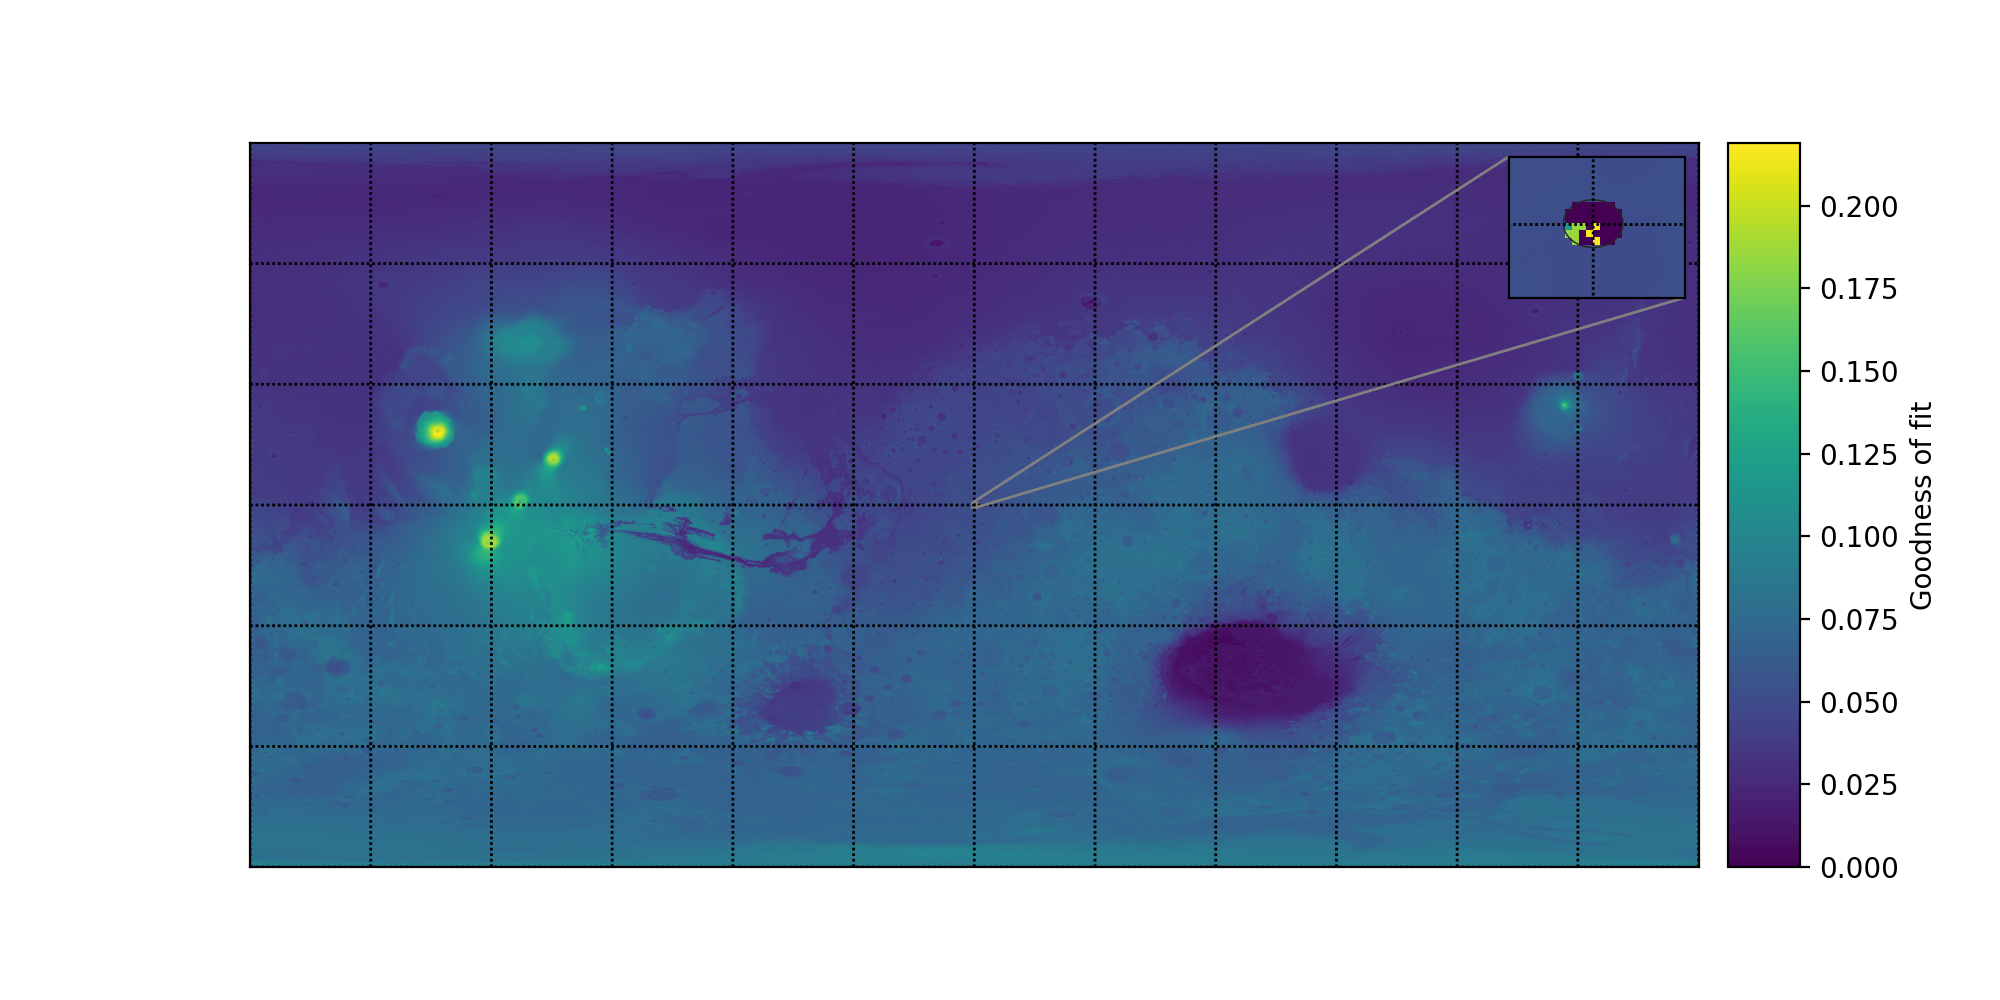

In [12]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
add_raster_to_map(basemap1, raster_elevation_array, 'Elevation ($m$)', add_colorbar = False)
add_raster_to_map(basemap1, center_distances_large, 'Goodness of fit', use_pcolormesh = True, add_colorbar = True)
add_path_to_map(subfigure1, ellipse_path_1, "Ellipse", facecolor = '#d9d9d9', alpha = 0.75, edgecolor = '#252525', linewidth = 0.25)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,False])
basemap1.drawparallels(np.arange(-90, 90, 30),labels=[False,False,False,False])

# Define the zoom and its displayed data
subfigure1_zoom = zoomed_inset_axes(subfigure1, zoom = 35, loc = 1)
add_raster_to_map(basemap1, raster_elevation_array, 'Elevation ($m$)', add_colorbar = False)
add_raster_to_map(basemap1, center_distances_large, 'Goodness of fit', add_colorbar = False)
add_path_to_map(subfigure1_zoom, ellipse_path_1, "Ellipse", facecolor = 'None', alpha = 1., edgecolor = '#252525', linewidth = 0.5)
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,False])
basemap1.drawparallels(np.arange(-90, 90, 30),labels=[False,False,False,False])
lon_0, lat_0 = longitude_array[slice_1_j[1], slice_1_i[0]], latitude_array[slice_1_j[1], slice_1_i[0]]
lon_1, lat_1 = longitude_array[slice_1_j[0], slice_1_i[1]], latitude_array[slice_1_j[0], slice_1_i[1]]
subfigure1_zoom.set_xlim(lon_0 - (lon_1 - lon_0)*0.75, lon_1 + (lon_1 - lon_0)*0.75)
subfigure1_zoom.set_ylim(lat_0 - (lat_1 - lat_0)*0.75, lat_1 + (lat_1 - lat_0)*0.75)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(subfigure1, subfigure1_zoom, loc1 = 2, loc2 = 4, fc = "none", ec = "0.5")
plt.show()

We compute the moving average and standard deviation.

&#9888; The computation time can take several tens of minutes.

In [13]:
from sklearn.externals.joblib import Parallel, delayed

@jit(nopython = True)
def compute_landing_ellipse_uncertainties_for_multiprocessing(ii, jj):
    
    ellipse_array = np.full((2, rad_longitude_array.shape[0], rad_longitude_array.shape[1]), np.nan)
    
    for j in jj:
        for i in ii:

            ellipse_array[0, j, i], ellipse_array[1, j, i] = compute_landing_ellipse_uncertainty(raster_rawfavorability_array,
                                                                                                 i,
                                                                                                 j,
                                                                                                 rad_longitude_array, 
                                                                                                 rad_latitude_array, 
                                                                                                 a, 
                                                                                                 b,
                                                                                                 azimuth,
                                                                                                 min_number_of_nodes, 
                                                                                                 max_number_of_nodes, 
                                                                                                 sigmoid_midlatitude,
                                                                                                 steepness,
                                                                                                 master_lon_min, 
                                                                                                 master_lon_max, 
                                                                                                 master_lat_min, 
                                                                                                 master_lat_max,    
                                                                                                 mars_radius)
            
    return ellipse_array

In [14]:
number_of_chunks = 20

min_number_of_nodes = 100
max_number_of_nodes = 500
sigmoid_midlatitude = 85
steepness = 0.75

In [15]:
%%time

jj = list(range(rad_longitude_array.shape[0]))
ii = list(range(rad_longitude_array.shape[1]))
chunk_size = math.ceil(len(ii)/number_of_chunks)
chunks = [ii[i:i + chunk_size] for i in range(0, len(ii), chunk_size)]

result_arrays = Parallel(n_jobs = number_of_chunks)(delayed(compute_landing_ellipse_uncertainties_for_multiprocessing)(chunk, jj) for chunk in chunks)
ellipse_mean_array = np.full((master_height, master_width), np.nan)
ellipse_stdev_array = np.full((master_height, master_width), np.nan)
for array in result_arrays:
    ellipse_mean_array[~np.isnan(array[0,:,:])] = array[0,:,:][~np.isnan(array[0,:,:])]
    ellipse_stdev_array[~np.isnan(array[1,:,:])] = array[1,:,:][~np.isnan(array[1,:,:])]

CPU times: user 38.5 s, sys: 5min 34s, total: 6min 12s
Wall time: 14min 18s


<IPython.core.display.Javascript object>


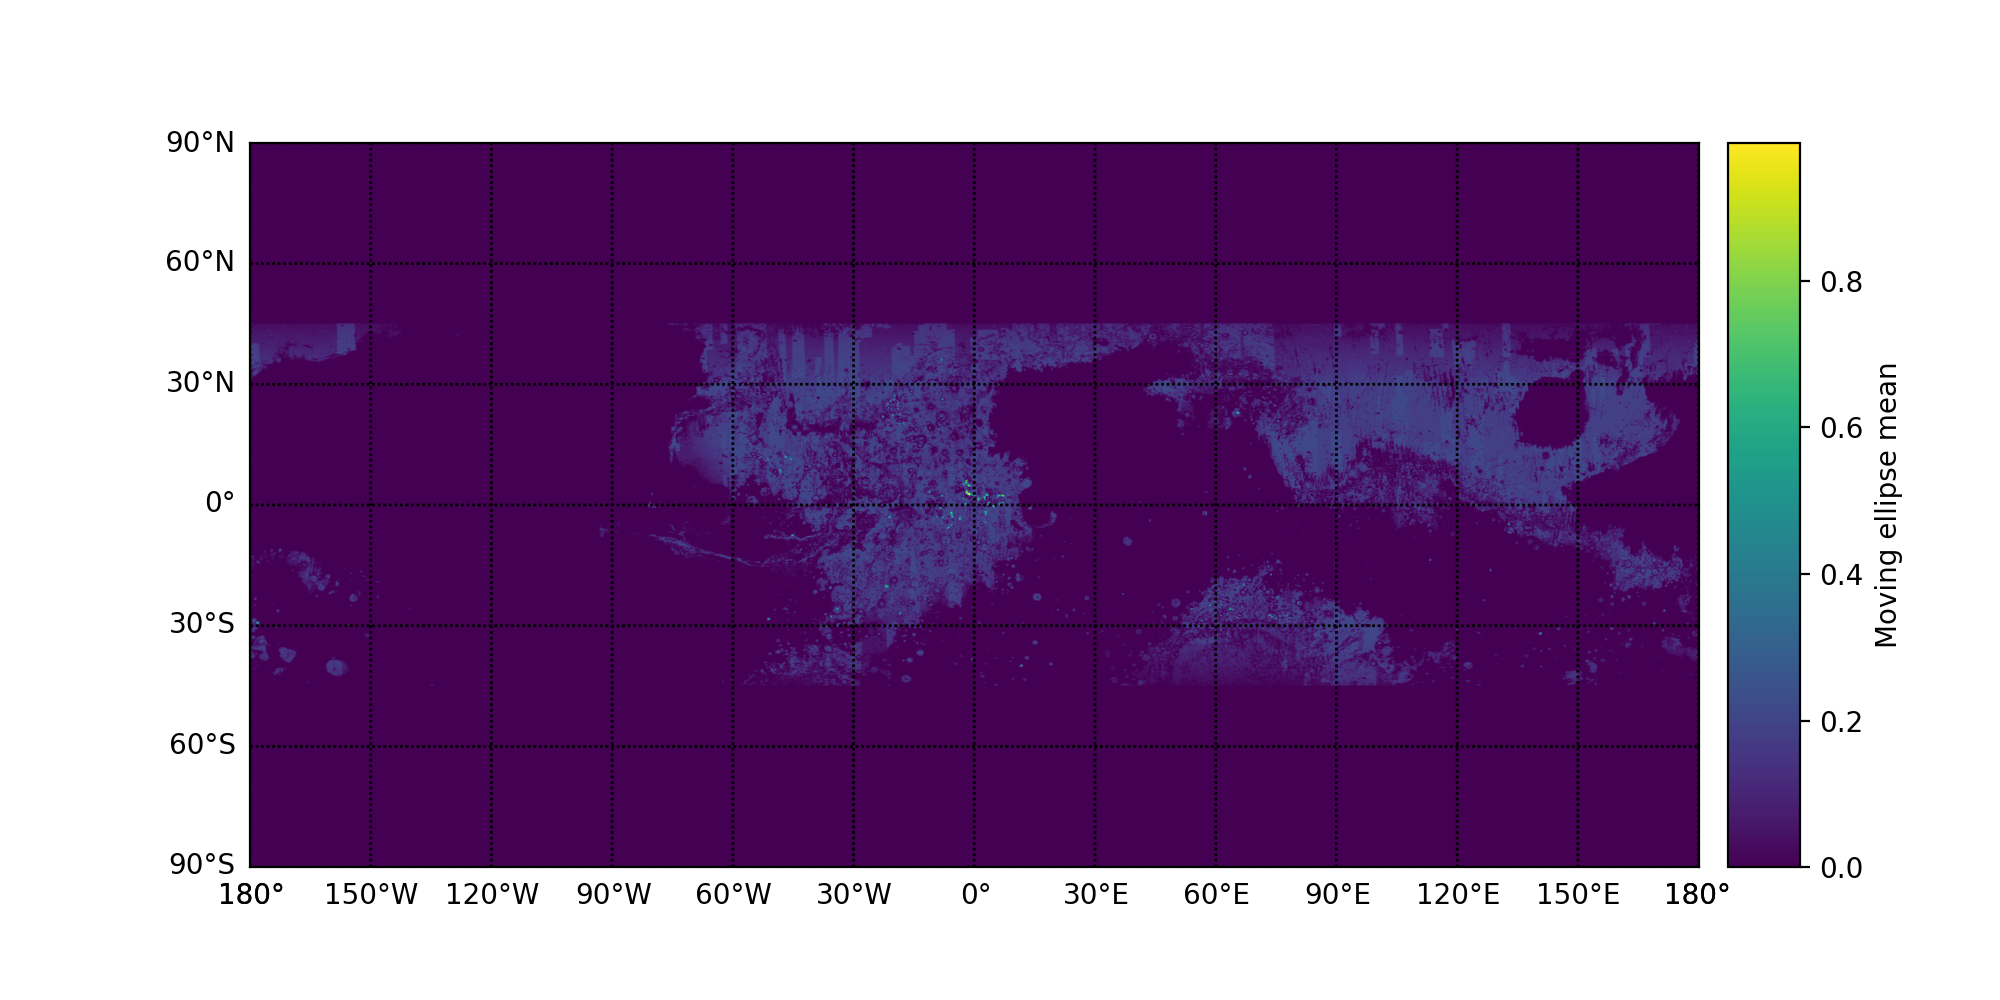

<IPython.core.display.Javascript object>


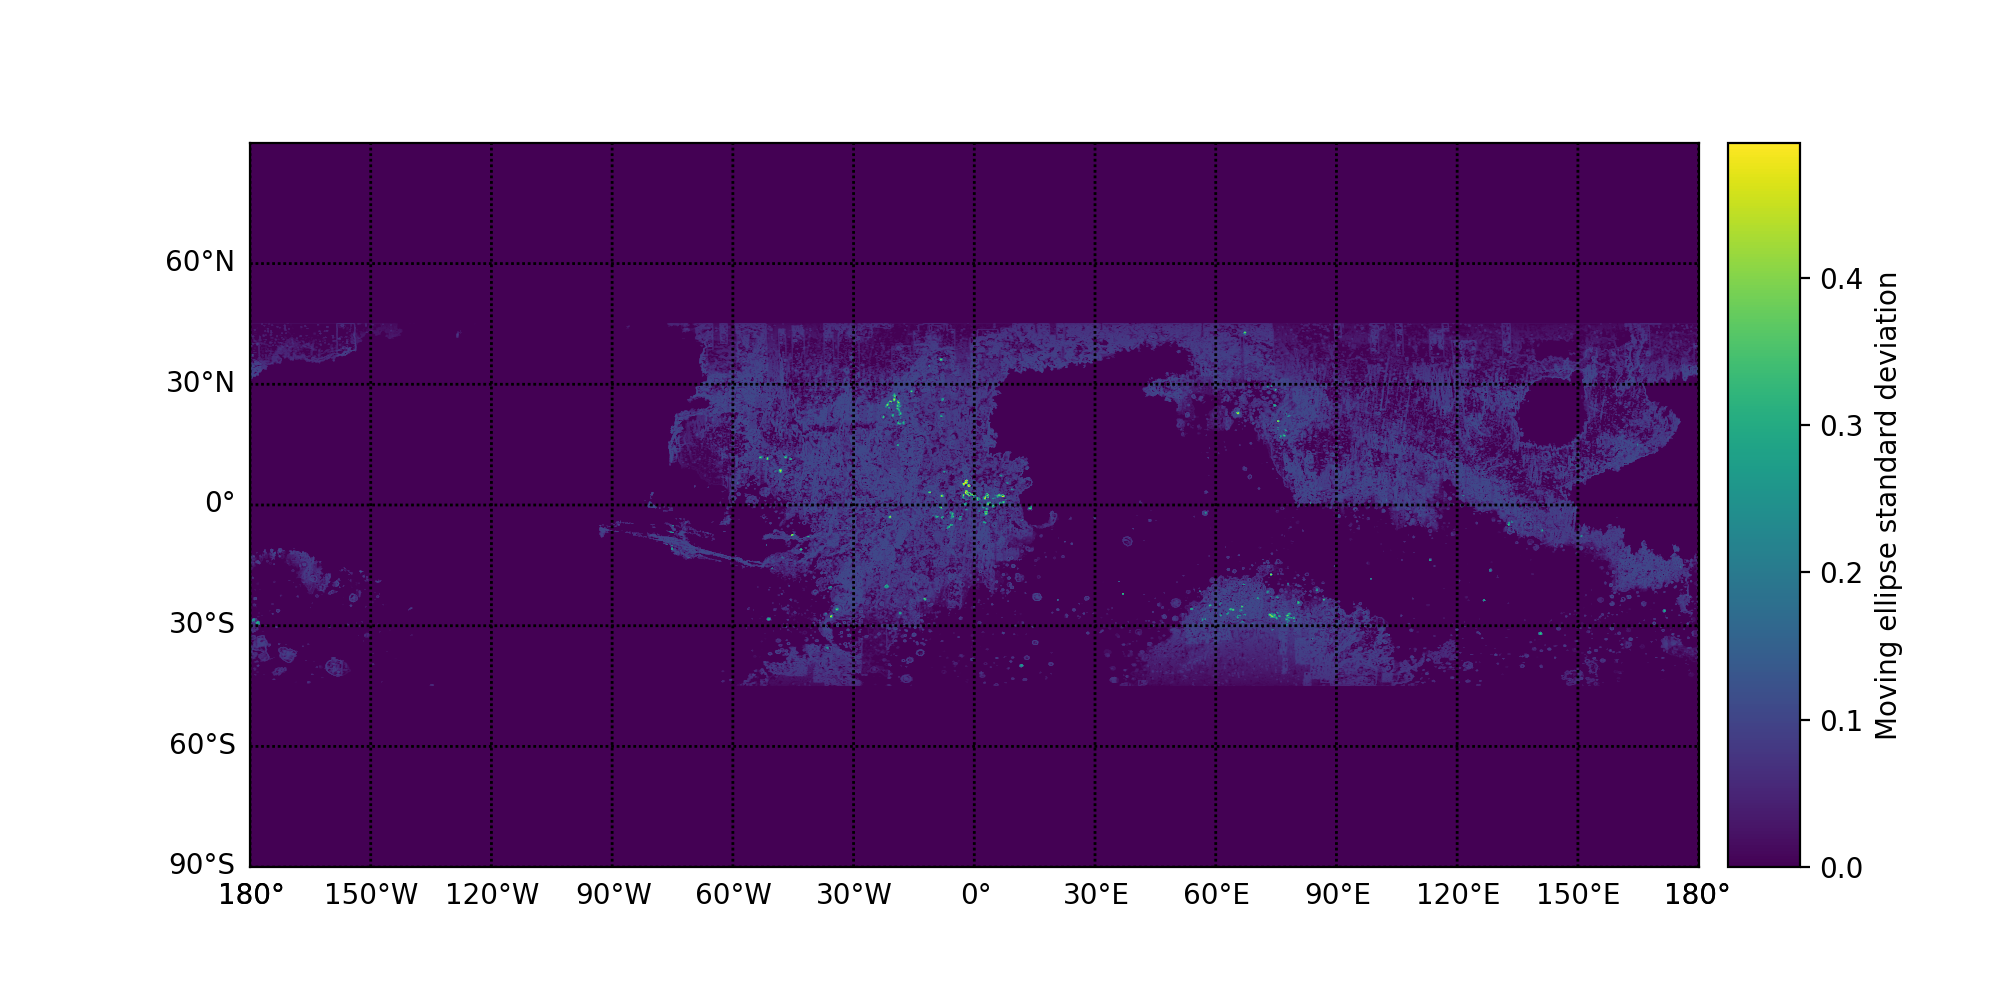

In [16]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, ellipse_mean_array, 'Moving ellipse mean')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, ellipse_stdev_array, 'Moving ellipse standard deviation')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 90, 30),labels=[True,False,False,False])
plt.show()

## Compute the favorability

The final favorability is the algebraic product of the average with the complement of the standard deviation. It provides for each cell a single measure of the favorability and its heterogeneity inside the landing ellipse centered on that cell.

In [17]:
favorability_array = algebraic_product(ellipse_mean_array, complement(ellipse_stdev_array))

<IPython.core.display.Javascript object>


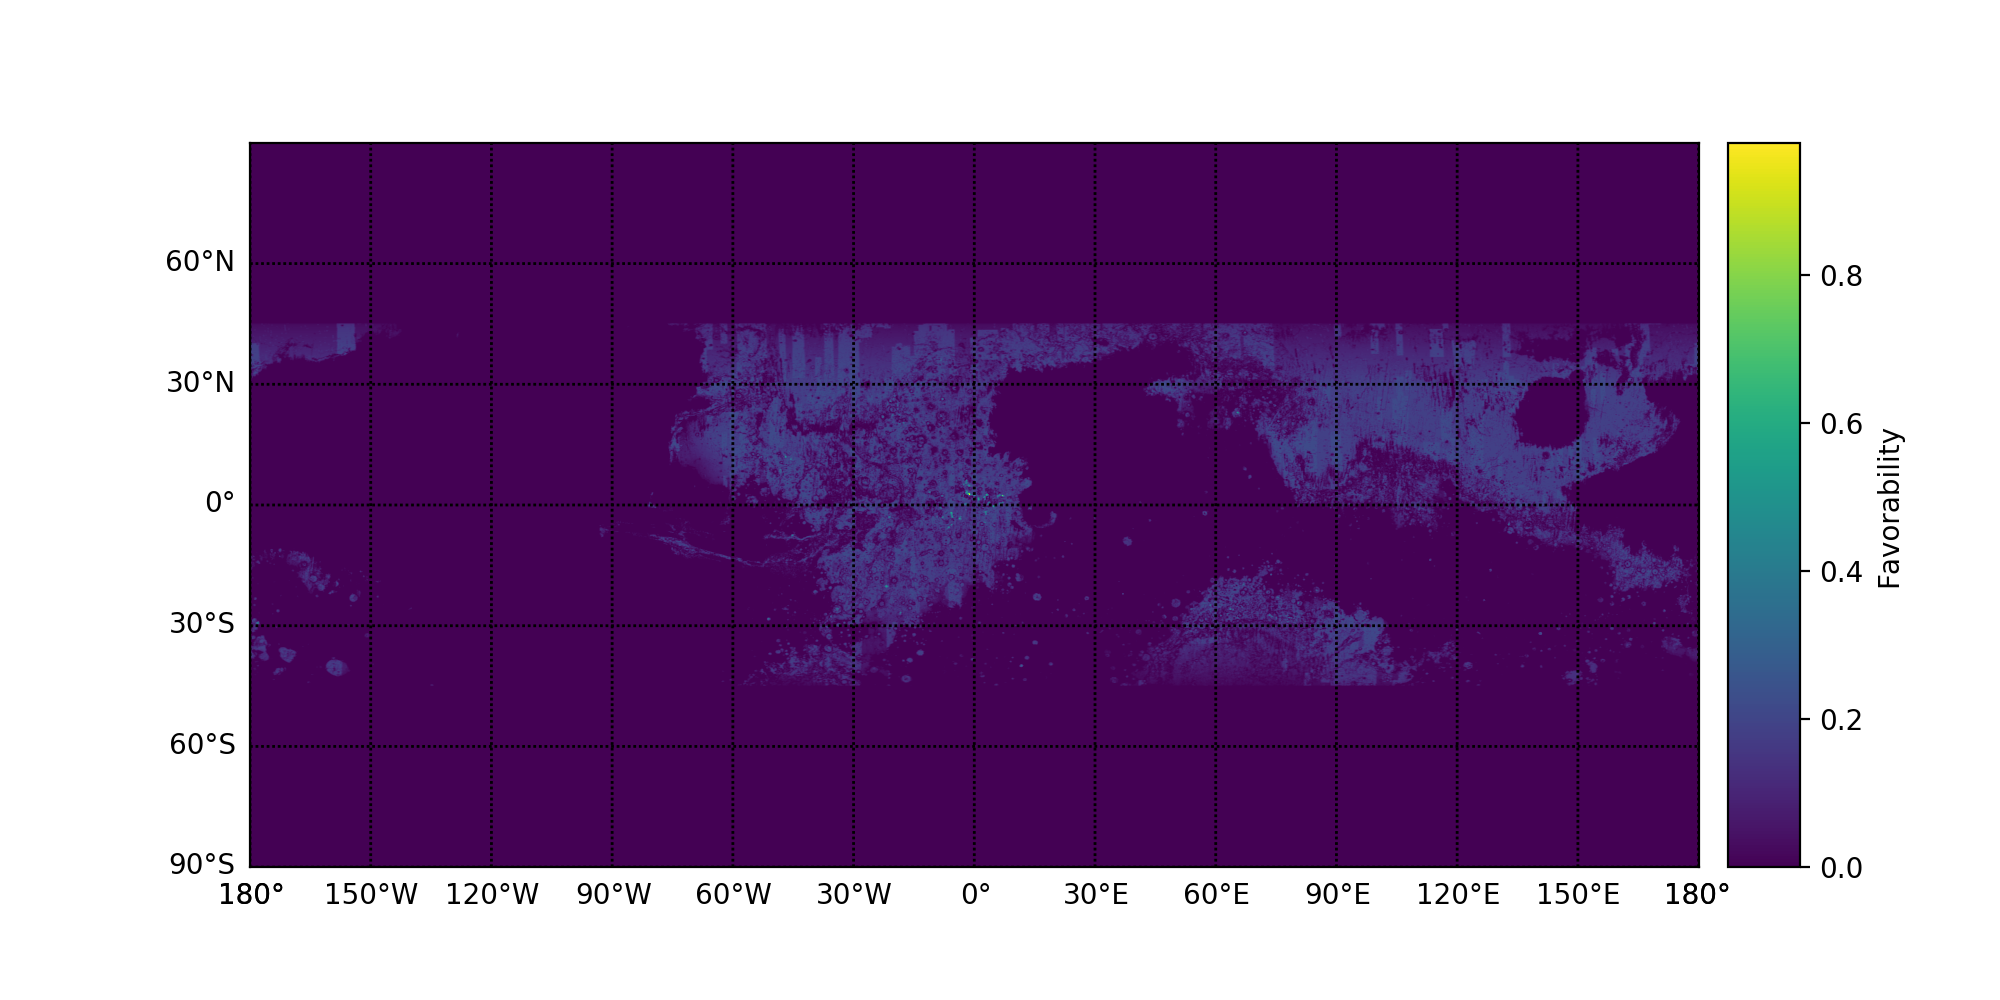

In [18]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, favorability_array, 'Favorability')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 90, 30),labels=[True,False,False,False])
plt.show()

We export the map to a .tif file.

In [19]:
raster_favorability = create_raster_from_array(favorability_array,           
                                               master_geotransform, 
                                               master_projection,
                                               file_type = 'GTiff',
                                               file_path = base_folder + output_folder + 'Results_Favorability_' + raster_name_affix + ellipse_affix + '.tif',
                                               options = ['COMPRESS=DEFLATE', 'PREDICTOR=3', 'TILED=YES'])
print_raster_info(raster_favorability)
raster_favorability = None

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )
